Updated pr 04/09 -- should be good

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm
plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.labelsize': 14,
    'legend.fontsize': 14
})
plt.rcParams["xtick.top"] = True    # enable top x-ticks
plt.rcParams["ytick.right"] = True  # enable right y-ticks
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [8]:
## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Al" 
_path = datapath + "bananas/" + iso
above_path = datapath+ "aboveban/" + iso
cuts1 = datapath + "cuts/totcuts.root"
cuts2 = datapath + "cuts/updatedgcuts.root"
#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
above_files = glob.glob(os.path.join(above_path, "*mlio.root"))

In [9]:
#### Loading in of the data files storing them in a dictionary
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
}
data_collection = {
    iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(4)} for isotope in data_files}

for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Al: 100%|██████████ 50/50 [02:56<00:00,  3.52s/file]


(1.6, 6.0)

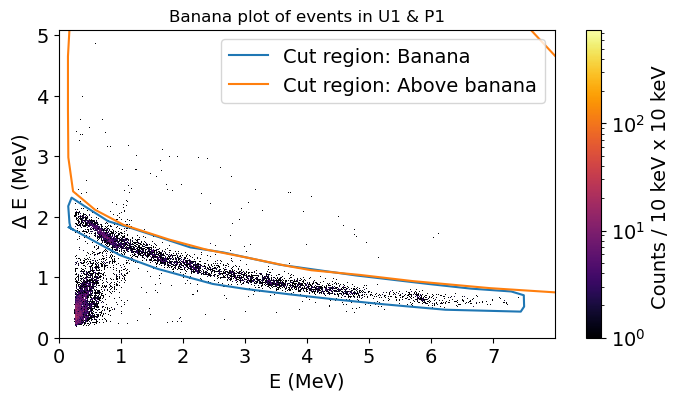

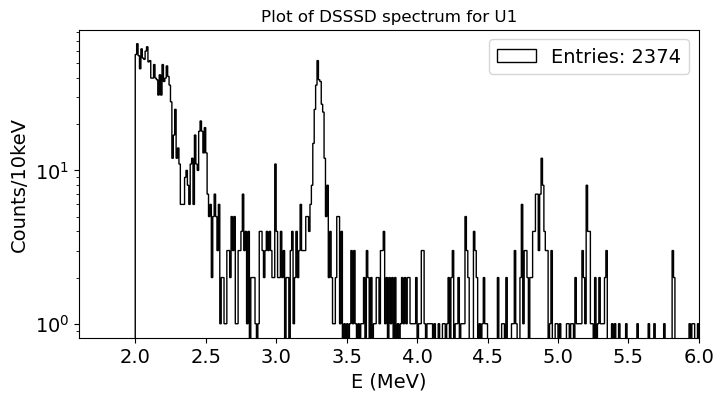

In [10]:
totcuts2 = uproot.open(cuts2)
totcuts1 = uproot.open(cuts1)

det = "id0"
xa, ya = totcuts1["abovebanU1"].values()#abovebanU1
xa = xa/1e3
ya = ya/1e3
xb, yb = totcuts2["id0cut;2"].values()
xb = xb/1e3
yb = yb/1e3

 
inbanana = np.column_stack((xb, yb))#(iis[0], js[0]))
inbanana_path = Path(inbanana)


isotope = "Al"

points = np.column_stack((data_collection[isotope][det]["bEdep"], data_collection[isotope][det]["fEdep"]))
inmask = inbanana_path.contains_points(points)

in_fedep = np.array(data_collection[isotope][det]["fEdep"])[inmask]
in_bedep = np.array(data_collection[isotope][det]["bEdep"])[inmask]
in_E = np.array(data_collection[isotope][det]["E"])[inmask]
##Plot of the cut regions
plt.figure(figsize=(8,4))
iso = "Al"

plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel("E (MeV)")
plt.ylabel(r" $\Delta$ E (MeV)")
plt.plot(xb, yb, label="Cut region: Banana")
plt.plot(xa, ya, label="Cut region: Above banana")
plt.legend(loc='upper right')
plt.title("Banana plot of events in U1 & P1")

## Plot of the energy deposited in the DSSSD detector where no telescope events have been matched
plt.figure(figsize=(8,4))
h = [j for j in data_collection[iso][det]["Edep"] if j>2]
plt.hist(h, bins=np.arange(0,7,0.01), histtype='step', color='k', label=f"Entries: {len(h)}")
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10keV")
plt.title("Plot of DSSSD spectrum for U1")
plt.xlim(1.6, 6)
#plt.savefig(outputdir + "dsssdspec.png")


In [11]:
## loading in cuts and sorting the data to only look into specific cut regions

xsa =[]
ysa =[]
for i in ["abovebanU1", "abovebanU2", "abovebanU3", "blank"]:
    if i=="blank":
        xsa.append(0)
        ysa.append(0)
    else:    
        x, y = totcuts1[i].values()
        xsa.append(np.array(x)/1e3)
        ysa.append(np.array(y)/1e3)
xs =[]
ys =[]
for i in ["id0cut;2", "id1cut","id2cut","id3cut"]:
    
    x, y = totcuts2[i].values()
    xs.append(np.array(x)/1e3)
    ys.append(np.array(y)/1e3)
   
in_fedep = []
in_bedep = []
in_E = []
above_events = []
above_fedep = []
above_bedep = []
above_E = []
above_fi = []
above_bi = []
in_fi = []
in_bi = []
in_events = []

isotope = iso
for k, i, j, l, h in zip(range(0,4),xs,ys, xsa, ysa):
    det = f"id{k}"
    inbanana = np.column_stack((i, j))
    inbanana_path = Path(inbanana)
    points = np.column_stack((data_collection[isotope][det]["bEdep"], data_collection[isotope][det]["fEdep"]))
    inmask = inbanana_path.contains_points(points)
    in_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[inmask])
    in_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[inmask])
    in_E.append(np.array(data_collection[isotope][det]["E"])[inmask])
    in_fi.append(np.array(data_collection[isotope][det]["FI"])[inmask])
    in_bi.append(np.array(data_collection[isotope][det]["BI"])[inmask])
    in_events.append(len(in_fedep[k]))
    if k!=3:
        abovebanana = np.column_stack((l, h))
        abovebanana_path = Path(abovebanana)
        abovemask = abovebanana_path.contains_points(points)
        above_E.append(np.array(data_collection[isotope][det]["E"])[abovemask])
        above_bedep.append(np.array(data_collection[isotope][det]["bEdep"])[abovemask])
        above_fedep.append(np.array(data_collection[isotope][det]["fEdep"])[abovemask])
        above_fi.append(np.array(data_collection[isotope][det]["FI"])[abovemask])
        above_bi.append(np.array(data_collection[isotope][det]["BI"])[abovemask]) 
        above_events.append(len(above_fedep[k]))

    else:
        continue
    

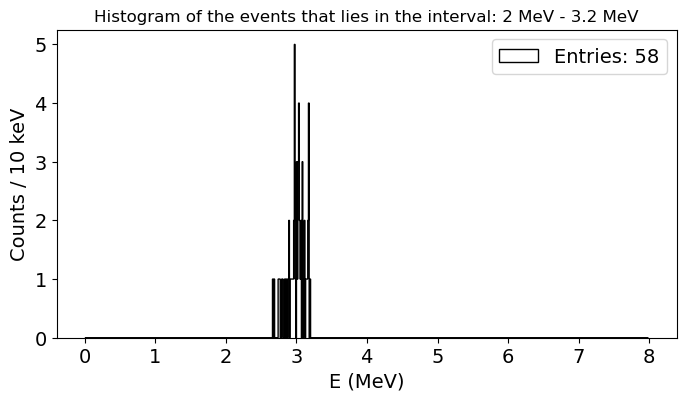

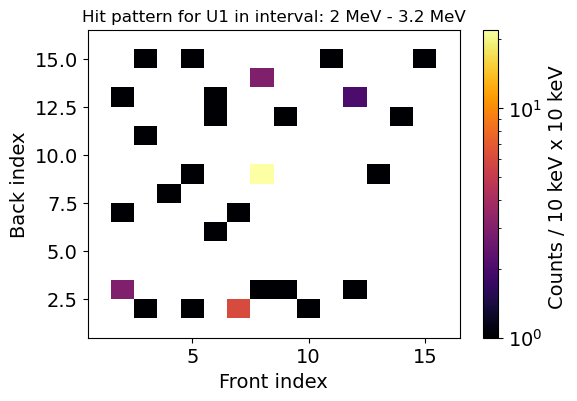

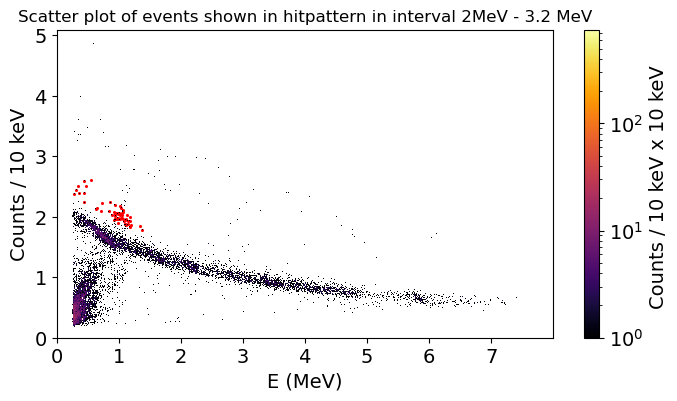

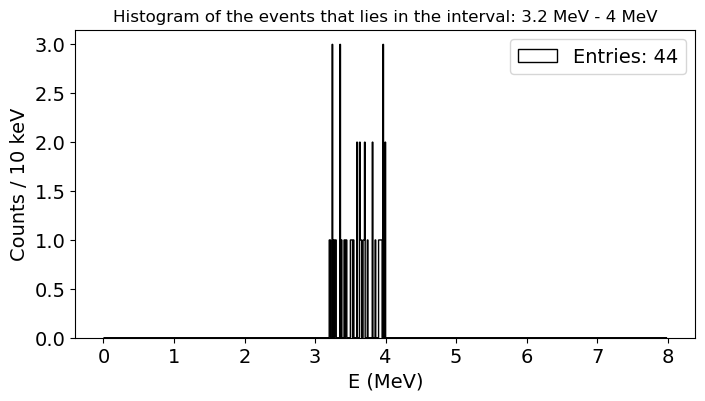

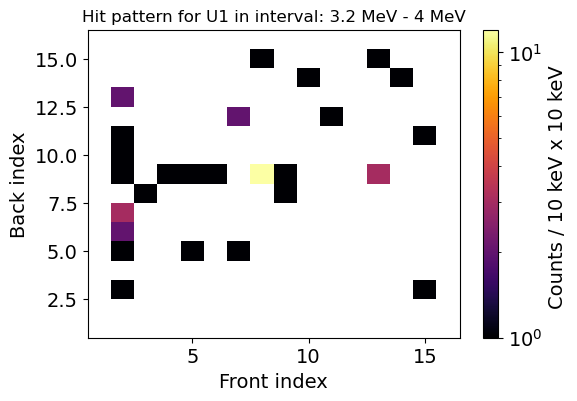

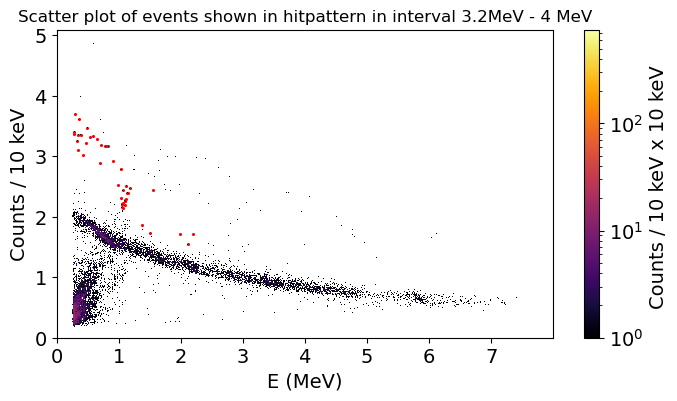

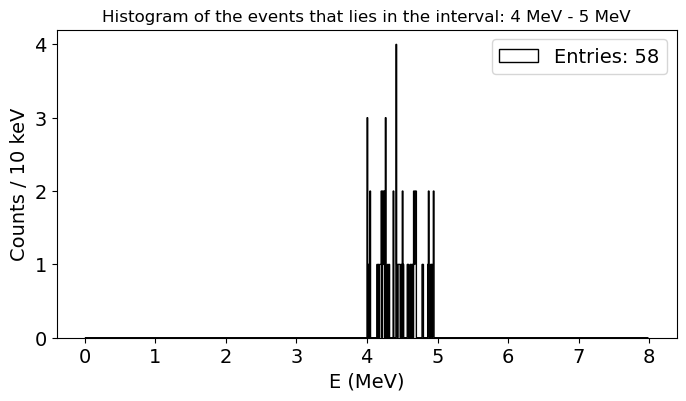

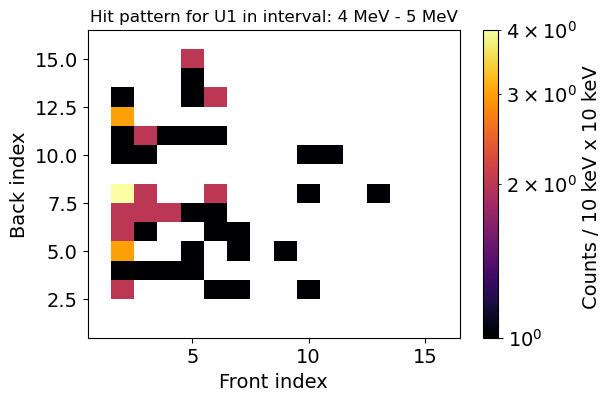

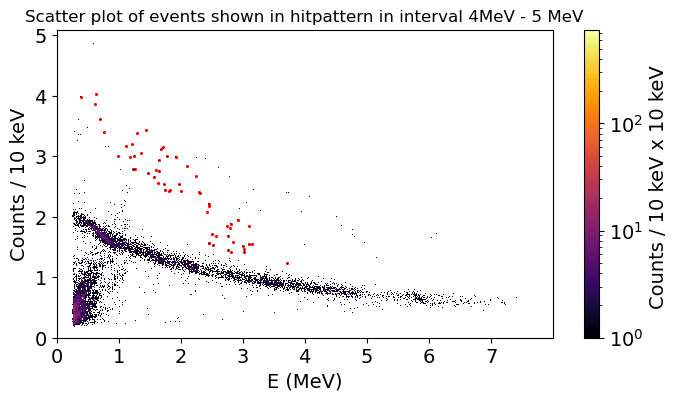

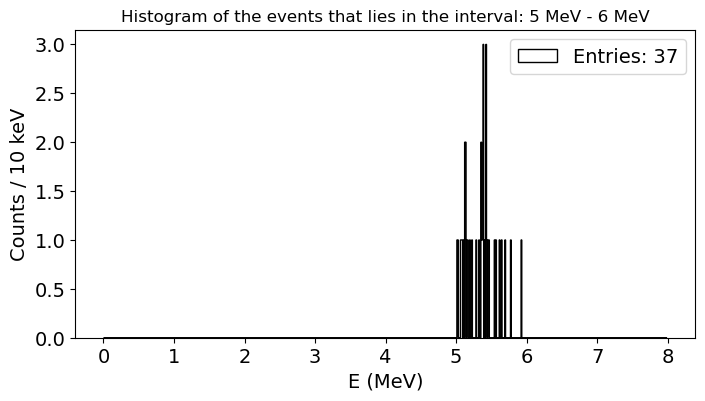

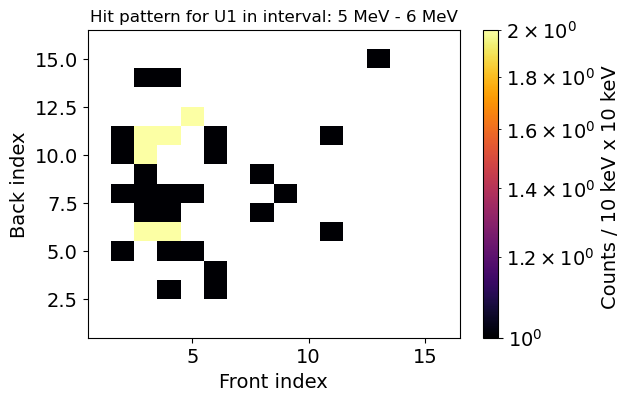

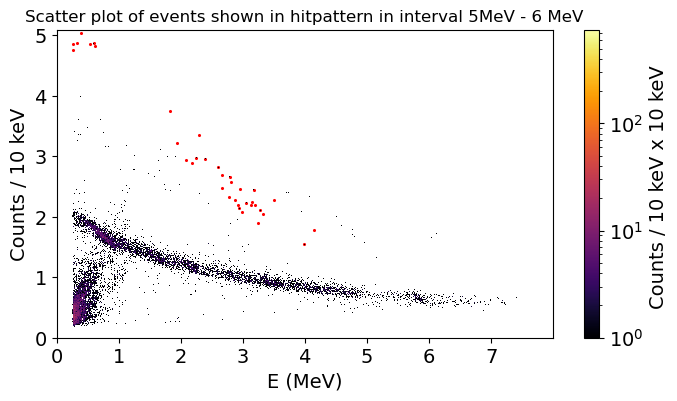

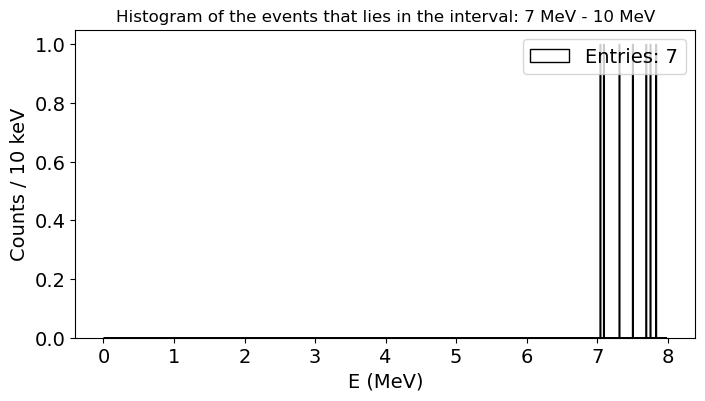

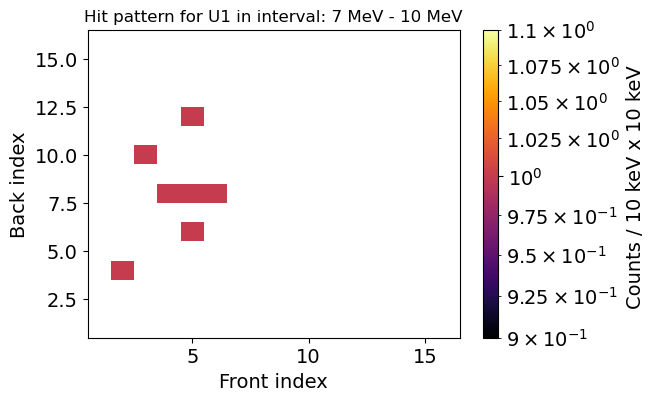

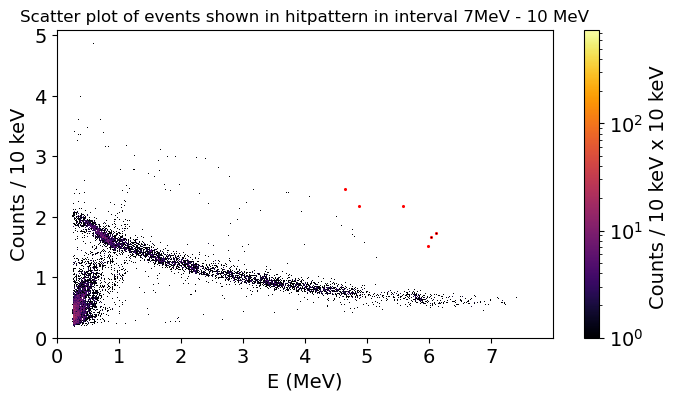

In [12]:
Eints = [(2,3.2),(3.2, 4),(4,5),(5,6),(7,10)]
for j in Eints:
    i = 0
    k = [a+b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.figure(figsize=(8,4))
    plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
    plt.legend()
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.title(f"Histogram of the events that lies in the interval: {j[0]} MeV - {j[1]} MeV")
    plt.figure(figsize=(6,4))
    f = [c-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    b = [d-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for U{i+1} in interval: {j[0]} MeV - {j[1]} MeV")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.figure(figsize=(8,4))
    g = [b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    h = [a for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if j[1]>a+b>j[0]]# and d!=9 and c!=8]
    plt.scatter(g, h, s=1.5, color='r')
    plt.hist2d(data_collection[iso]["id0"]["bEdep"], data_collection[iso]["id0"]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        
    plt.title(f"Scatter plot of events shown in hitpattern in interval {j[0]}MeV - {j[1]} MeV")
    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")


Text(0, 0.5, 'Back index')

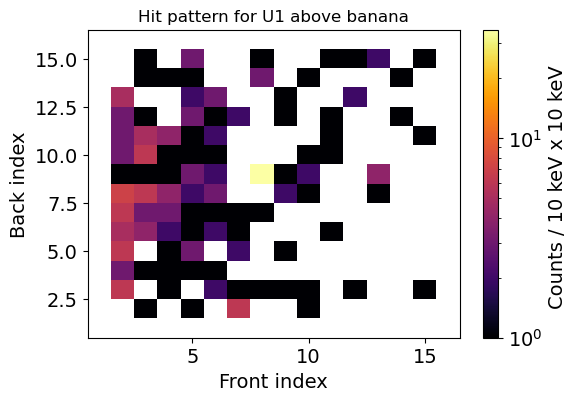

In [13]:
i=0
plt.figure(figsize=(6,4))
f = [c-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i])]# and d!=9 and c!=8]
b = [d-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i])]# and d!=9 and c!=8]
plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for U{i+1} above banana")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')

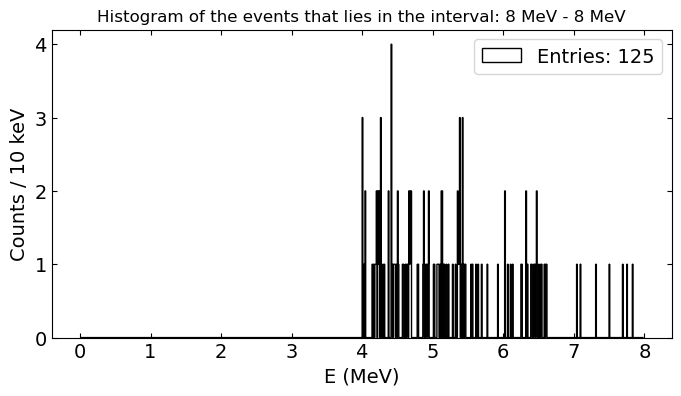

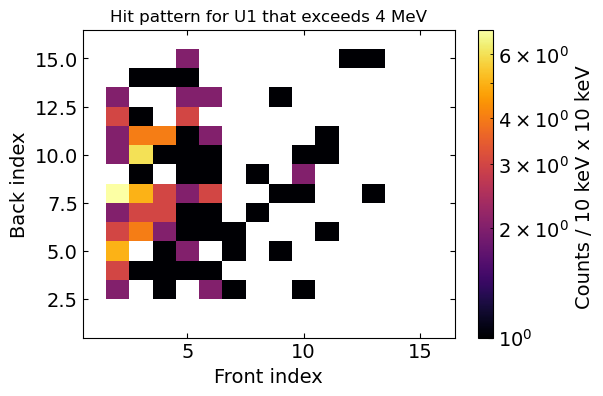

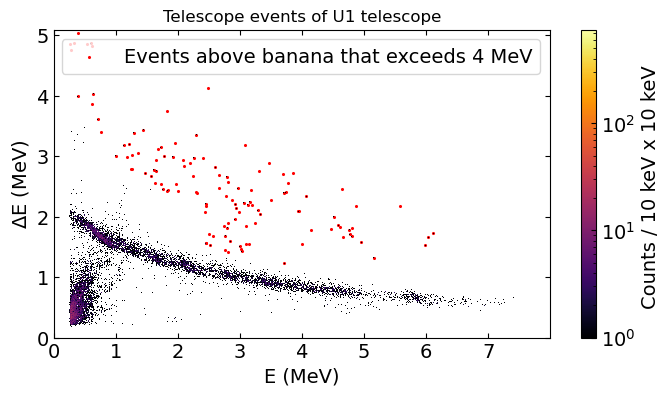

In [23]:
i = 0
k = [a+b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if a+b>4]# and d!=9 and c!=8]
plt.figure(figsize=(8,4))
plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
plt.legend()
plt.xlabel("E (MeV)")
plt.ylabel("Counts / 10 keV")
plt.title(f"Histogram of the events that lies in the interval: {j[0]} MeV - {j[1]} MeV")
plt.gca().tick_params(direction='in')

plt.figure(figsize=(6,4))
f = [c-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if a+b>4]# and d!=9 and c!=8]
b = [d-0.5 for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if a+b>4]# and d!=9 and c!=8]
plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for U{i+1} that exceeds 4 MeV")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')
plt.gca().tick_params(direction='in')
plt.savefig("alhitpat.png")

plt.figure(figsize=(8,4))
g = [b for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if a+b>4]# and d!=9 and c!=8]
h = [a for a,b,c,d in zip(above_fedep[i],above_bedep[i], above_fi[i], above_bi[i]) if a+b>4]# and d!=9 and c!=8
plt.scatter(g, h, s=1.5, color='r', label="Events above banana that exceeds 4 MeV")
plt.hist2d(data_collection[iso]["id0"]["bEdep"], data_collection[iso]["id0"]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True, label="U1 telescope data")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        
plt.title(f"Telescope events of U1 telescope")
plt.xlabel("E (MeV)")
plt.ylabel(r"$\Delta$E (MeV)")
plt.gca().tick_params(direction='in')
plt.legend(loc='upper right')
plt.savefig("albanana.pdf")


Text(0, 0.5, 'Back index')

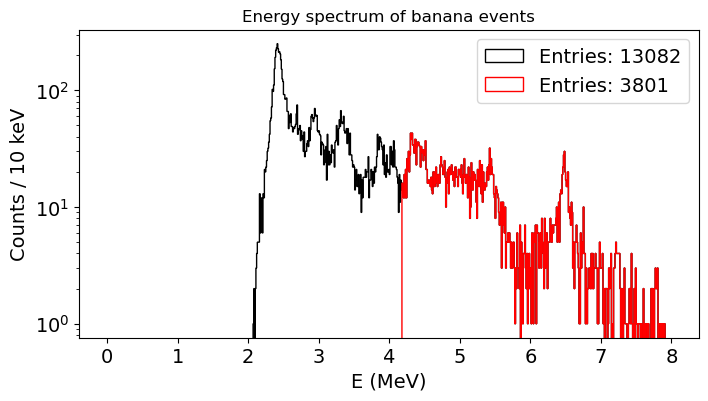

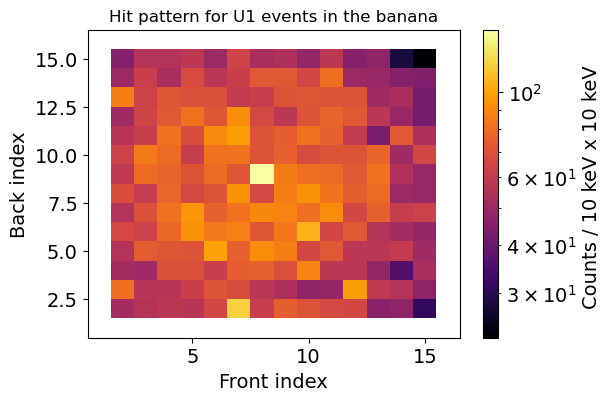

In [15]:
k = [a+b for a,b,c,d in zip(in_fedep[0],in_bedep[0], in_fi[0], in_bi[0])]
plt.figure(figsize=(8,4))
plt.hist(k, bins=np.arange(0,8, 0.01), histtype='step', color='k', label=f"Entries: {len(k)}")
k = np.array(k)
e = k[(k>4.18)]
plt.hist(e, bins=np.arange(0,8, 0.01), histtype='step', color='r', label=f"Entries: {len(e)}")
plt.legend()
plt.xlabel("E (MeV)")
plt.ylabel("Counts / 10 keV")
plt.title("Energy spectrum of banana events")
plt.yscale('log')
plt.figure(figsize=(6,4))
plt.hist2d(in_fi[0]-0.5, in_bi[0]-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for U1 events in the banana")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')

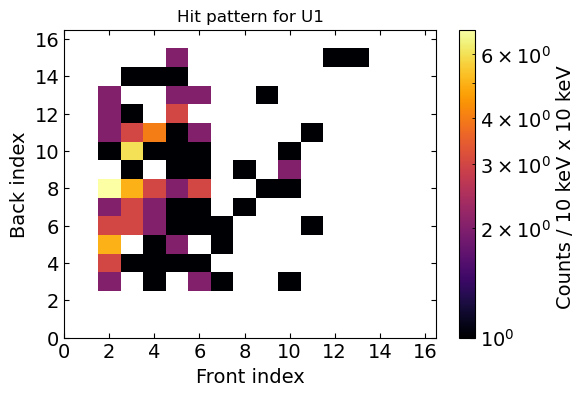

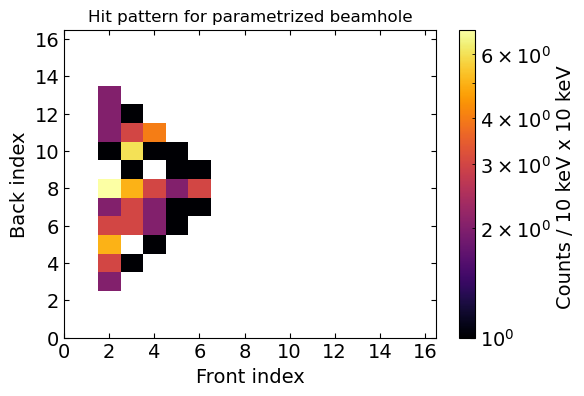

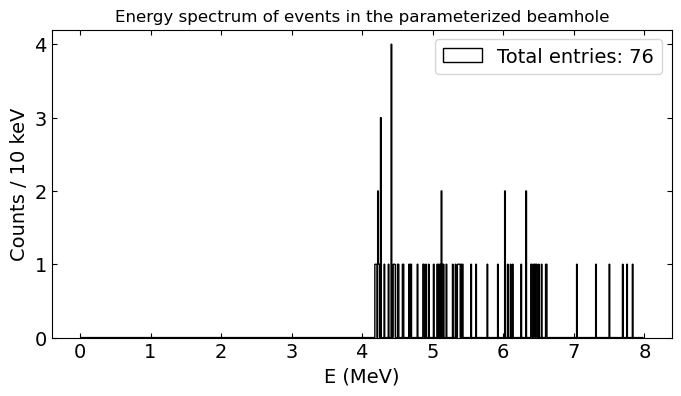

In [28]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(6,4))
f = [c-0.5 for a,b,c,d in zip(above_fedep[0],above_bedep[0], above_fi[0], above_bi[0]) if a+b>4.18]# and d!=9 and c!=8]
b = [d-0.5 for a,b,c,d in zip(above_fedep[0],above_bedep[0], above_fi[0], above_bi[0]) if a+b>4.18]# and d!=9 and c!=8]
plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for U1")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')
plt.gca().tick_params(direction='in', which='both')



plt.xticks(np.arange(0,17,2))
plt.yticks(np.arange(0,17,2))
plt.savefig("alhitpat.png")


plt.figure(figsize=(6,4))
fier = []; bier = []; fe=[]; be=[]
fis = [2,3,4,5,6,7]; bis=[(3,13), (4,12), (5,11), (6,10), (7,9), (8,8)]
for i,j in zip(fis,bis):
    for a,b,c,d in zip(above_fedep[0],above_bedep[0], above_fi[0], above_bi[0]):
        if c==i:
            if j[0]<=d<=j[1] and a+b>4.18:
                fier.append(c)
                bier.append(d)
                fe.append(a)
                be.append(b)

plt.hist2d(fier, bier, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for parametrized beamhole")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')
plt.gca().tick_params(direction='in')

plt.xticks(np.arange(0,17,2))
plt.yticks(np.arange(0,17,2))
plt.savefig("parhitpat.png")


plt.figure(figsize=(8,4))
k = [a+b for a,b in zip(fe,be)]
k = np.array(k)
#e = k[(4.49>k) & (k>4.12)]
#plt.vlines(4.49, 0, 4, color='c', ls='--')
#plt.vlines(4.12, 0, 4, color='c', ls='--')

plt.hist(k, bins=np.arange(0,8,0.01),histtype='step', color='k', label=f"Total entries: {len(k)}")
plt.title("Energy spectrum of events in the parameterized beamhole")
plt.xlabel("E (MeV)")
plt.ylabel("Counts / 10 keV")
plt.legend()
plt.gca().tick_params(direction='in')
plt.show()


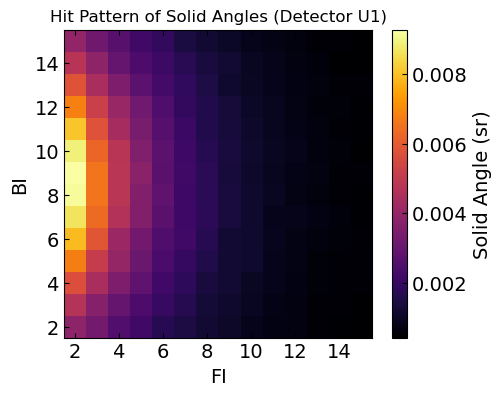

Total solid angle coverage of parameterized zone: 1.540049994855807
Total solid angle of U1:  0.06751635822601958
Estimated activity percentage:
From beamhole: 8.06(0.9447445452318589) %
From target:   91.94(2.675254410444245) %


In [26]:
import numpy as np
import matplotlib.pyplot as plt

u1sa = 6.7516358226019575/100 ## max solid angle of U1

# Load file, skipping lines starting with "#"
data_hole = np.loadtxt("/home/haue/repositories/Masters/build/ano.dat", comments="#")

cropped = data_hole[1:-1, 1:-1]
# Plot as a 2D map (hit pattern)
plt.figure(figsize=(5,4))
im = plt.imshow(cropped.T, cmap="inferno", origin="lower")
plt.colorbar(im, label="Solid Angle (sr)")
plt.title("Hit Pattern of Solid Angles (Detector U1)")

ticks = np.arange(cropped.shape[0])
labels = np.arange(2, 2 + cropped.shape[0])  # 2–15

plt.xticks(ticks[::2], labels[::2])
plt.yticks(ticks[::2], labels[::2])
plt.gca().tick_params(direction='in')

plt.xlabel("FI")
plt.ylabel("BI")
plt.savefig("hitsim.pdf")
plt.show()


# Example selection (like your loop)
fis = [2,3,4,5,6,7]
bis = [(3,13), (4,12), (5,11), (6,10), (7,9), (8,8)]

total_solid_angle = 0.0
selected_pixels = []

for fi, (bi_min, bi_max) in zip(fis, bis):
    for bi in range(bi_min, bi_max+1):   # inclusive range
        sa = cropped[fi-2, bi-2]         # shift indices by -2
        total_solid_angle += sa
        selected_pixels.append((fi, bi, sa))

print("Total solid angle coverage of parameterized zone:", total_solid_angle/(4*np.pi)*100)
print("Total solid angle of U1: ", u1sa)
total_solid_angle = total_solid_angle/(4*np.pi)
tot = (len(k) / total_solid_angle) + (3801 / u1sa)
print(f"Estimated activity percentage:")
err_beamhole = (len(k)/total_solid_angle) / tot * 100 * np.sqrt((np.sqrt(len(k))/len(k))**2 + ((np.sqrt(len(k))/total_solid_angle + np.sqrt(3801)/u1sa)/(len(k)/total_solid_angle + 3801/u1sa))**2)
err_target = (3801/u1sa) / tot * 100 * np.sqrt((np.sqrt(3801)/3801)**2 + ((np.sqrt(len(k))/total_solid_angle + np.sqrt(3801)/u1sa)/(len(k)/total_solid_angle + 3801/u1sa))**2)

print(f"From beamhole: {(len(k) / total_solid_angle) / tot * 100:.2f}({err_beamhole}) %")
print(f"From target:   {(3801 / u1sa) / tot * 100:.2f}({err_target}) %")
